In [2]:
!pip install pyspark
!pip install findspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 5.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=abb91473c239a0d3ba5da9bf58d60e0c62d65dcf433d1330bc3d5ab16fa0ca05
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
from pyspark import SparkContext, SparkConf
import os
import findspark
import math
from pyspark.sql import SparkSession
import time

In [4]:
findspark.init()

In [5]:
spark_conf = SparkConf()\
    .setAppName("Recommendation System")\
    .setMaster("local[*]")

# Tạo SparkSession sử dụng cấu hình từ SparkConf
spark = SparkSession.builder\
    .config(conf=spark_conf)\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/25 06:04:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load data

In [6]:
events_df = spark.read.csv("/kaggle/input/ecommerce-dataset/events.csv", header=True, inferSchema=True)
category_tree_df = spark.read.csv("/kaggle/input/ecommerce-dataset/category_tree.csv", header=True, inferSchema=True)
item_properties_1_df = spark.read.csv("/kaggle/input/ecommerce-dataset/item_properties_part1.csv", header=True, inferSchema=True)
item_properties_2_df = spark.read.csv("/kaggle/input/ecommerce-dataset/item_properties_part2.csv", header=True, inferSchema=True)
events_df.show()

+-------------+---------+---------+------+-------------+
|    timestamp|visitorid|    event|itemid|transactionid|
+-------------+---------+---------+------+-------------+
|1433221332117|   257597|     view|355908|         NULL|
|1433224214164|   992329|     view|248676|         NULL|
|1433221999827|   111016|     view|318965|         NULL|
|1433221955914|   483717|     view|253185|         NULL|
|1433221337106|   951259|     view|367447|         NULL|
|1433224086234|   972639|     view| 22556|         NULL|
|1433221923240|   810725|     view|443030|         NULL|
|1433223291897|   794181|     view|439202|         NULL|
|1433220899221|   824915|     view|428805|         NULL|
|1433221204592|   339335|     view| 82389|         NULL|
|1433222162373|   176446|     view| 10572|         NULL|
|1433221701252|   929206|     view|410676|         NULL|
|1433224229496|    15795|     view| 44872|         NULL|
|1433223697356|   598426|     view|156489|         NULL|
|1433224078165|   223343|     v

In [7]:
category_tree_df.show()

+----------+--------+
|categoryid|parentid|
+----------+--------+
|      1016|     213|
|       809|     169|
|       570|       9|
|      1691|     885|
|       536|    1691|
|       231|    NULL|
|       542|     378|
|      1146|     542|
|      1140|     542|
|      1479|    1537|
|        83|    1621|
|       688|     893|
|       257|     312|
|      1640|     622|
|       963|    1281|
|       412|    1110|
|       948|    1110|
|       934|    1110|
|       148|    1110|
|        12|    1110|
+----------+--------+
only showing top 20 rows



In [8]:
item_properties_1_df.printSchema()

root
 |-- timestamp: long (nullable = true)
 |-- itemid: integer (nullable = true)
 |-- property: string (nullable = true)
 |-- value: string (nullable = true)



In [9]:
item_properties_1_df.show()

+-------------+------+----------+--------------------+
|    timestamp|itemid|  property|               value|
+-------------+------+----------+--------------------+
|1435460400000|460429|categoryid|                1338|
|1441508400000|206783|       888|1116713 960601 n2...|
|1439089200000|395014|       400|n552.000 639502 n...|
|1431226800000| 59481|       790|          n15360.000|
|1431831600000|156781|       917|              828513|
|1436065200000|285026| available|                   0|
|1434250800000| 89534|       213|             1121373|
|1431831600000|264312|         6|              319724|
|1433646000000|229370|       202|             1330310|
|1434250800000| 98113|       451|     1141052 n48.000|
|1439089200000|450113|       888|1038400 45956 n50...|
|1435460400000|244127|       400|n552.000 639502 n...|
|1439694000000|264319|       227|      1283144 353870|
|1439694000000|348323|       839|     1026952 1162729|
|1434250800000|169055|       790|          n21000.000|
|143727480

In [10]:
item_properties_1_df.describe().show()

24/05/25 06:05:15 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+------------------+------------------+------------------+
|summary|           timestamp|            itemid|          property|             value|
+-------+--------------------+------------------+------------------+------------------+
|  count|            10999999|          10999999|          10999999|          10999999|
|   mean|1.435157818568119E12|233385.09199719017| 606.3963609386216| 576358.8481853632|
| stddev| 3.327652516443273E9|134825.84618898891|308.96150272981305|428680.83397365344|
|    min|       1431226800000|                 0|                 0|                 0|
|    max|       1442113200000|            466866|        categoryid|         nInfinity|
+-------+--------------------+------------------+------------------+------------------+



Columns

In [11]:
events_df.columns

['timestamp', 'visitorid', 'event', 'itemid', 'transactionid']

Describe

In [12]:
events_df.describe().show()

+-------+--------------------+-----------------+---------+-----------------+------------------+
|summary|           timestamp|        visitorid|    event|           itemid|     transactionid|
+-------+--------------------+-----------------+---------+-----------------+------------------+
|  count|             2756101|          2756101|  2756101|          2756101|             22457|
|   mean|1.436424488348111...|701922.8832292431|     NULL|234922.4783750668| 8826.497795787505|
| stddev| 3.366312180000979E9|405687.5208087459|     NULL|134195.4252136468|5098.9962898740605|
|    min|       1430622004384|                0|addtocart|                3|                 0|
|    max|       1442545187788|          1407579|     view|           466867|             17671|
+-------+--------------------+-----------------+---------+-----------------+------------------+



Missing data

In [13]:
# Filter for non-NULL values in the "transactionid" column
filtered_data = events_df.filter(events_df["transactionid"].isNotNull())
filtered_data.show()

+-------------+---------+-----------+------+-------------+
|    timestamp|visitorid|      event|itemid|transactionid|
+-------------+---------+-----------+------+-------------+
|1433222276276|   599528|transaction|356475|         4000|
|1433193500981|   121688|transaction| 15335|        11117|
|1433193915008|   552148|transaction| 81345|         5444|
|1433176736375|   102019|transaction|150318|        13556|
|1433174518180|   189384|transaction|310791|         7244|
|1433184261340|   350566|transaction| 54058|         8796|
|1433184261371|   350566|transaction|284871|         8796|
|1433182772710|   404403|transaction|150100|         5216|
|1433164275232|   505565|transaction|243566|        11713|
|1433180403455|   945184|transaction|245400|         2415|
|1433177808042|  1406787|transaction|336832|        15915|
|1433179768674|   820159|transaction|202052|        14924|
|1433202096802|   319880|transaction|  7943|        11615|
|1433199718976|   608628|transaction|185598|        1195

In [14]:
# Filter for rows where the "transactionid" is equal to "NULL"
filtered_data_null = events_df.filter(events_df["transactionid"].isNull())
filtered_data_null.show()

+-------------+---------+---------+------+-------------+
|    timestamp|visitorid|    event|itemid|transactionid|
+-------------+---------+---------+------+-------------+
|1433221332117|   257597|     view|355908|         NULL|
|1433224214164|   992329|     view|248676|         NULL|
|1433221999827|   111016|     view|318965|         NULL|
|1433221955914|   483717|     view|253185|         NULL|
|1433221337106|   951259|     view|367447|         NULL|
|1433224086234|   972639|     view| 22556|         NULL|
|1433221923240|   810725|     view|443030|         NULL|
|1433223291897|   794181|     view|439202|         NULL|
|1433220899221|   824915|     view|428805|         NULL|
|1433221204592|   339335|     view| 82389|         NULL|
|1433222162373|   176446|     view| 10572|         NULL|
|1433221701252|   929206|     view|410676|         NULL|
|1433224229496|    15795|     view| 44872|         NULL|
|1433223697356|   598426|     view|156489|         NULL|
|1433224078165|   223343|     v

### Kiểm tra số lượng phân vùng

In [15]:
# Kiểm tra số phân vùng ban đầu
initial_partitions = item_properties_1_df.rdd.getNumPartitions()
print(f"Initial partitions: {initial_partitions}")

Initial partitions: 4


In [16]:
df_repartitioned = item_properties_1_df.repartition(5)
repartitioned_partitions = df_repartitioned.rdd.getNumPartitions()
print(f"Repartitioned partitions: {repartitioned_partitions}")

Repartitioned partitions: 5


Minh Họa việc phân vùng

In [18]:
# Dữ liệu mẫu
data = [
    (1, "Product A", 100),
    (2, "Product B", 150),
    (3, "Product C", 200),
    (4, "Product D", 250),
    (5, "Product E", 300),
    (6, "Product F", 350),
    (7, "Product G", 400),
    (8, "Product H", 450),
    (9, "Product I", 500),
    (10, "Product J", 550)
]

# Tên cột
columns = ["product_id", "product_name", "price"]

# Tạo DataFrame
df = spark.createDataFrame(data, columns)

# Hiển thị DataFrame ban đầu
df.show()

+----------+------------+-----+
|product_id|product_name|price|
+----------+------------+-----+
|         1|   Product A|  100|
|         2|   Product B|  150|
|         3|   Product C|  200|
|         4|   Product D|  250|
|         5|   Product E|  300|
|         6|   Product F|  350|
|         7|   Product G|  400|
|         8|   Product H|  450|
|         9|   Product I|  500|
|        10|   Product J|  550|
+----------+------------+-----+



In [19]:
# Kiểm tra số phân vùng ban đầu
initial_partitions = df.rdd.getNumPartitions()
print(f"Initial partitions: {initial_partitions}")


Initial partitions: 4


In [20]:
# Tăng số lượng phân vùng lên 4
df_repartitioned = df.repartition(4)
repartitioned_partitions = df_repartitioned.rdd.getNumPartitions()
print(f"Repartitioned partitions: {repartitioned_partitions}")

# Hiển thị nội dung các phân vùng
def show_partition_contents(df):
    partition_data = df.rdd.glom().collect()
    for idx, part in enumerate(partition_data):
        print(f"Partition {idx}: {part}")

print("Data in each partition after repartition:")
show_partition_contents(df_repartitioned)


Repartitioned partitions: 4
Data in each partition after repartition:
Partition 0: [Row(product_id=6, product_name='Product F', price=350), Row(product_id=7, product_name='Product G', price=400)]
Partition 1: [Row(product_id=1, product_name='Product A', price=100), Row(product_id=3, product_name='Product C', price=200), Row(product_id=5, product_name='Product E', price=300), Row(product_id=9, product_name='Product I', price=500)]
Partition 2: [Row(product_id=2, product_name='Product B', price=150), Row(product_id=4, product_name='Product D', price=250), Row(product_id=10, product_name='Product J', price=550)]
Partition 3: [Row(product_id=8, product_name='Product H', price=450)]


In [21]:
# Giảm số lượng phân vùng xuống 2
df_coalesced = df_repartitioned.coalesce(2)
coalesced_partitions = df_coalesced.rdd.getNumPartitions()
print(f"Coalesced partitions: {coalesced_partitions}")

print("Data in each partition after coalesce:")
show_partition_contents(df_coalesced)


Coalesced partitions: 2
Data in each partition after coalesce:
Partition 0: [Row(product_id=6, product_name='Product F', price=350), Row(product_id=7, product_name='Product G', price=400), Row(product_id=2, product_name='Product B', price=150), Row(product_id=4, product_name='Product D', price=250), Row(product_id=10, product_name='Product J', price=550)]
Partition 1: [Row(product_id=1, product_name='Product A', price=100), Row(product_id=3, product_name='Product C', price=200), Row(product_id=5, product_name='Product E', price=300), Row(product_id=9, product_name='Product I', price=500), Row(product_id=8, product_name='Product H', price=450)]


repartition: Tăng hoặc giảm số lượng phân vùng bằng cách phân phối lại dữ liệu đồng đều giữa các phân vùng. Điều này có thể dẫn đến việc di chuyển dữ liệu lớn giữa các nút.

coalesce: Giảm số lượng phân vùng một cách hiệu quả bằng cách hợp nhất các phân vùng hiện có mà không di chuyển nhiều dữ liệu. coalesce ít tốn kém tài nguyên hơn so với repartition.

# Các lệnh truy vấn cơ bản trên pyspark

In [35]:
from pyspark.sql.functions import countDistinct, desc
from pyspark.sql.functions import to_timestamp, from_unixtime, col, when
from pyspark.sql.functions import max, min

Tính toán số lượng khách hàng 

In [36]:
events_df.select('visitorid').distinct().count()

1407580

Các mặt hàng có lượng khách như thế nào ?

In [37]:
luongkhach = events_df.groupBy('itemid').agg(countDistinct('visitorid').alias('item_count')).orderBy(desc('item_count'))
luongkhach.show()

+------+----------+
|itemid|item_count|
+------+----------+
|187946|      2912|
|  5411|      2079|
|370653|      1577|
|461686|      1393|
|219512|      1370|
| 96924|      1359|
|298009|      1342|
|335975|      1154|
|384302|      1154|
|151444|      1103|
|441668|      1080|
|309778|      1055|
|234255|       988|
|257040|       986|
|434782|       938|
|142466|       936|
|111530|       926|
|112782|       887|
|320130|       886|
|102306|       858|
+------+----------+
only showing top 20 rows



Hiển thị mặt hàng theo thời gian thực

In [38]:
tem_df = events_df.withColumn('timestamp', from_unixtime(col('timestamp') / 1000).cast('timestamp'))

# Hiển thị DataFrame
tem_df.show(truncate=False)

+-------------------+---------+---------+------+-------------+
|timestamp          |visitorid|event    |itemid|transactionid|
+-------------------+---------+---------+------+-------------+
|2015-06-02 05:02:12|257597   |view     |355908|NULL         |
|2015-06-02 05:50:14|992329   |view     |248676|NULL         |
|2015-06-02 05:13:19|111016   |view     |318965|NULL         |
|2015-06-02 05:12:35|483717   |view     |253185|NULL         |
|2015-06-02 05:02:17|951259   |view     |367447|NULL         |
|2015-06-02 05:48:06|972639   |view     |22556 |NULL         |
|2015-06-02 05:12:03|810725   |view     |443030|NULL         |
|2015-06-02 05:34:51|794181   |view     |439202|NULL         |
|2015-06-02 04:54:59|824915   |view     |428805|NULL         |
|2015-06-02 05:00:04|339335   |view     |82389 |NULL         |
|2015-06-02 05:16:02|176446   |view     |10572 |NULL         |
|2015-06-02 05:08:21|929206   |view     |410676|NULL         |
|2015-06-02 05:50:29|15795    |view     |44872 |NULL   

Số lượng khách cao và thấp nhất xem một mặt hàng

In [40]:
luongkhach.select(max('item_count')).show()
luongkhach.select(min('item_count')).show()

+---------------+
|max(item_count)|
+---------------+
|           2912|
+---------------+



+---------------+
|min(item_count)|
+---------------+
|              1|
+---------------+



Đếm số lượng mục (itemid) có giá trị của thuộc tính (property) là "available"

In [41]:
item_properties_1_df.filter(item_properties_1_df['property'] == 'available').count()

817387

Inner Join

In [42]:
joined_df = events_df.join(item_properties_1_df, 'itemid')
joined_df.show()

+------+-------------+---------+-----+-------------+-------------+---------+--------------+
|itemid|    timestamp|visitorid|event|transactionid|    timestamp| property|         value|
+------+-------------+---------+-----+-------------+-------------+---------+--------------+
|    22|1441804170057|   280824| view|         NULL|1431226800000|      112|        679677|
|    22|1441804170057|   280824| view|         NULL|1440298800000|      790|    n21240.000|
|    22|1441804170057|   280824| view|         NULL|1438484400000|      790|    n21240.000|
|    22|1441804170057|   280824| view|         NULL|1437879600000|      790|    n21240.000|
|    22|1441804170057|   280824| view|         NULL|1439694000000|      790|    n21240.000|
|    22|1441804170057|   280824| view|         NULL|1433646000000|      314|        769062|
|    22|1441804170057|   280824| view|         NULL|1440903600000|      790|    n21240.000|
|    22|1441804170057|   280824| view|         NULL|1442113200000|      790|    

Multiple Joins

In [43]:
joined_df = events_df.join(item_properties_1_df, 'itemid').join(category_tree_df, events_df['itemid'] == category_tree_df['categoryid'])
joined_df.show()

+------+-------------+---------+-----+-------------+-------------+---------+--------------+----------+--------+
|itemid|    timestamp|visitorid|event|transactionid|    timestamp| property|         value|categoryid|parentid|
+------+-------------+---------+-----+-------------+-------------+---------+--------------+----------+--------+
|    22|1441804170057|   280824| view|         NULL|1431226800000|      112|        679677|        22|    1550|
|    22|1441804170057|   280824| view|         NULL|1440298800000|      790|    n21240.000|        22|    1550|
|    22|1441804170057|   280824| view|         NULL|1438484400000|      790|    n21240.000|        22|    1550|
|    22|1441804170057|   280824| view|         NULL|1437879600000|      790|    n21240.000|        22|    1550|
|    22|1441804170057|   280824| view|         NULL|1439694000000|      790|    n21240.000|        22|    1550|
|    22|1441804170057|   280824| view|         NULL|1433646000000|      314|        769062|        22|  

Phía dưới là visitor id 102019 và hành trình mua hàng từ viewing đến transaction (purchase)

In [44]:
events_df.filter(events_df.visitorid == 102019).orderBy('timestamp').show()

+-------------+---------+-----------+------+-------------+
|    timestamp|visitorid|      event|itemid|transactionid|
+-------------+---------+-----------+------+-------------+
|1433175714335|   102019|       view| 49521|         NULL|
|1433175801314|   102019|  addtocart| 49521|         NULL|
|1433175812596|   102019|       view|150318|         NULL|
|1433175871497|   102019|       view| 49521|         NULL|
|1433175894837|   102019|       view| 49521|         NULL|
|1433175945872|   102019|       view|150318|         NULL|
|1433176042269|   102019|       view| 49521|         NULL|
|1433176736375|   102019|transaction|150318|        13556|
|1433176736422|   102019|transaction| 49521|        13556|
+-------------+---------+-----------+------+-------------+



Tìm ra top 50 mặt hàng được xem nhiều nhất

In [139]:
def top_viewed_and_purchased_items(events_df):
    events_df = events_df.withColumn('event_type', when(col('event') == 'view', 'view').otherwise('purchase'))

    viewed_and_purchased_items_df = events_df.groupBy('itemid') \
                                              .pivot('event_type') \
                                              .count() \
                                              .na.fill(0) \
                                              .withColumn('total_events', col('view') + col('purchase')) \
                                              .orderBy(col('total_events').desc())
    
    viewed_and_purchased_items_df.show()
    return viewed_and_purchased_items_df

viewed_and_purchased_items_df = top_viewed_and_purchased_items(events_df)


+------+--------+----+------------+
|itemid|purchase|view|total_events|
+------+--------+----+------------+
|187946|       2|3410|        3412|
|461686|     439|2539|        2978|
|  5411|       9|2325|        2334|
|370653|       0|1854|        1854|
|219512|      60|1740|        1800|
|257040|     116|1531|        1647|
|298009|       0|1642|        1642|
| 96924|       0|1633|        1633|
|309778|      63|1565|        1628|
|384302|      80|1528|        1608|
|320130|     174|1333|        1507|
|  7943|     143|1346|        1489|
|111530|      50|1397|        1447|
|441668|      44|1389|        1433|
|335975|       0|1428|        1428|
|234255|      93|1214|        1307|
|190000|      67|1164|        1231|
|151444|       0|1230|        1230|
| 37029|      96|1131|        1227|
|369447|     111|1103|        1214|
+------+--------+----+------------+
only showing top 20 rows



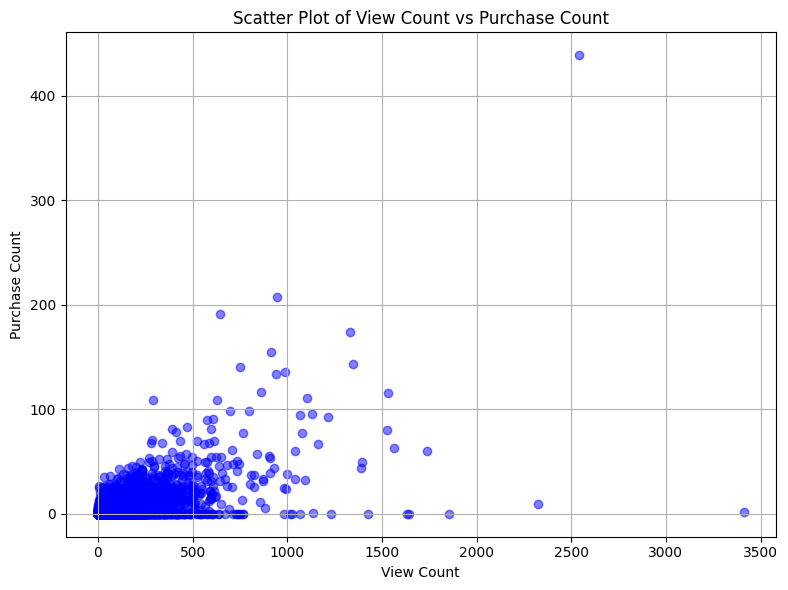

In [140]:
# Chuyển DataFrame thành Pandas DataFrame để sử dụng cho việc vẽ biểu đồ
viewed_and_purchased = viewed_and_purchased_items_df.toPandas()

# Lấy dữ liệu cho biểu đồ scatter plot
view_counts = viewed_and_purchased['view']
purchase_counts = viewed_and_purchased['purchase']

# Vẽ biểu đồ scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(view_counts, purchase_counts, color='blue', alpha=0.5)
plt.xlabel('View Count')
plt.ylabel('Purchase Count')
plt.title('Scatter Plot of View Count vs Purchase Count')
plt.grid(True)
plt.tight_layout()
plt.show()

In [70]:
from pyspark.sql.functions import count
# Tạo DataFrame mới từ events_df
visitor_events_df = events_df.groupBy('visitorid') \
                              .pivot('event') \
                              .agg(count('event')) \
                              .na.fill(0) \
                              .orderBy(desc('view'))
# Hiển thị DataFrame mới
visitor_events_df.show()


+---------+---------+-----------+----+
|visitorid|addtocart|transaction|view|
+---------+---------+-----------+----+
|  1150086|      719|        559|6479|
|   530559|      419|        286|3623|
|   895999|       56|         50|2368|
|   152963|      371|        349|2304|
|   163561|      124|         92|2194|
|   371606|      110|         94|2141|
|   286616|      120|         75|2057|
|   892013|        1|          0|2023|
|   638482|        1|          0|1828|
|   684514|      231|        189|1826|
|   836635|      124|         90|1720|
|   316850|       48|         20|1684|
|    79627|        4|          0|1619|
|   861299|      230|        188|1573|
|  1297062|      155|        136|1531|
|   518659|       84|         40|1490|
|   994820|      119|         71|1471|
|    85734|       26|         15|1420|
|  1161163|      131|        115|1417|
|    76757|      296|        185|1402|
+---------+---------+-----------+----+
only showing top 20 rows



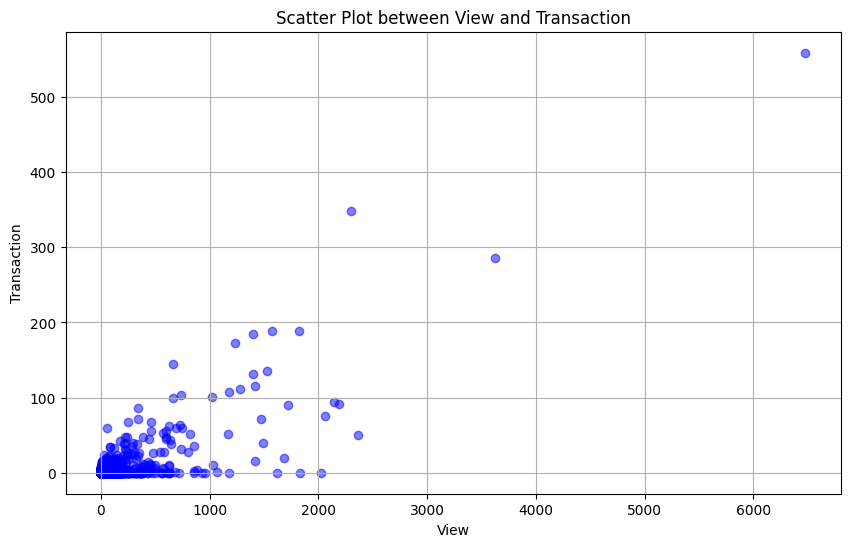

In [71]:
visitorid = visitor_events_df.select('visitorid').rdd.flatMap(lambda x: x).collect()
view = visitor_events_df.select('view').rdd.flatMap(lambda x: x).collect()
transaction = visitor_events_df.select('transaction').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.scatter(view, transaction, color='blue', alpha=0.5)
plt.title('Scatter Plot between View and Transaction')
plt.xlabel('View')
plt.ylabel('Transaction')
plt.grid(True)
plt.show()


In [47]:
sorted_visitors = events_df.filter(events_df.event == 'transaction').select('visitorid').orderBy('visitorid').distinct()

# Lấy danh sách các visitor đã mua hàng
buying_visitors = sorted_visitors.collect()

In [51]:
buying_visitors[:5]

[Row(visitorid=1168808),
 Row(visitorid=361387),
 Row(visitorid=897873),
 Row(visitorid=186588),
 Row(visitorid=213089)]

# Task 1 : Dựa vào dữ liệu khách hàng để đưa ra đề xuất

In [110]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from sklearn.preprocessing import StandardScaler

In [121]:
transaction_view_df = visitor_events_df.select('transaction', 'view')
transaction_view_df = transaction_view_df.filter(transaction_view_df['view'] >= 10)

In [122]:
transaction_view_df = transaction_view_df.toPandas()

In [123]:
transaction_view_df

,transaction,view
0,559,6479
1,286,3623
2,50,2368
3,349,2304
4,92,2194
...,...,...
21089,0,10
21090,0,10
21091,0,10
21092,0,10


In [124]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(transaction_view_df)

# convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=transaction_view_df.columns)
scaled_df

,transaction,view
0,83.762798,74.818179
1,42.815120,41.711715
2,7.417127,27.163882
3,52.264584,26.422000
4,13.716770,25.146891
...,...,...
21089,-0.082448,-0.169816
21090,-0.082448,-0.169816
21091,-0.082448,-0.169816
21092,-0.082448,-0.169816


In [126]:
transaction_df = spark.createDataFrame(scaled_df)

# Show the resulting PySpark DataFrame
transaction_df.show()

+--------------------+------------------+
|         transaction|              view|
+--------------------+------------------+
|   83.76279807046667|  74.8181789621834|
|   42.81511991271629|41.711715130226445|
|   7.417127073049296|27.163881758690742|
|   52.26458410296638|26.422000216237926|
|  13.716769866549356|25.146891315147148|
|  14.016752856716025| 24.53252066280341|
|  11.166914450132666| 23.55880113833409|
|-0.08244768111743936| 23.16467656890603|
|-0.08244768111743936|20.904256244245104|
|  28.265944889632824|20.881072446043454|
|  13.416786876382686|19.652331141355976|
|   2.917382220549255|19.235022773726268|
|-0.08244768111743936|18.481549332172627|
|   28.11595339454949|17.948321973534664|
|  20.316395650216084|17.461462211300002|
|  5.9172121222159495|16.986194348166165|
|  10.566948469799327|16.765948265250486|
|  2.1674247451325814|  16.1747614111084|
|  17.166574253466056|16.139985713805924|
|  27.665978909299483|15.966107227293543|
+--------------------+------------

In [133]:
# Add a column with row numbers
transaction_df = transaction_df.withColumn("row_id", monotonically_increasing_id())

# Filter out rows with row number greater than 0
transaction_df = transaction_df.filter(transaction_df.row_id > 0)

# Drop the row_id column
transaction_df = transaction_df.drop("row_id")

# Show the resulting DataFrame
transaction_df.show()

+--------------------+------------------+
|         transaction|              view|
+--------------------+------------------+
|   42.81511991271629|41.711715130226445|
|   7.417127073049296|27.163881758690742|
|   52.26458410296638|26.422000216237926|
|  13.716769866549356|25.146891315147148|
|  14.016752856716025| 24.53252066280341|
|  11.166914450132666| 23.55880113833409|
|-0.08244768111743936| 23.16467656890603|
|-0.08244768111743936|20.904256244245104|
|  28.265944889632824|20.881072446043454|
|  13.416786876382686|19.652331141355976|
|   2.917382220549255|19.235022773726268|
|-0.08244768111743936|18.481549332172627|
|   28.11595339454949|17.948321973534664|
|  20.316395650216084|17.461462211300002|
|  5.9172121222159495|16.986194348166165|
|  10.566948469799327|16.765948265250486|
|  2.1674247451325814|  16.1747614111084|
|  17.166574253466056|16.139985713805924|
|  27.665978909299483|15.966107227293543|
|  19.716429669882743|15.954515328192718|
+--------------------+------------

In [134]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Create a VectorAssembler to assemble the 'transaction' and 'view' columns into a single 'features' column
assembler = VectorAssembler(inputCols=['transaction', 'view'], outputCol="features")

# Transform the DataFrame to include the "features" column
dataset_kmean = assembler.transform(transaction_df)

# Now let's try running the KMeans algorithm
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(dataset_kmean)

# Make predictions
predictions = model.transform(dataset_kmean)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


Silhouette with squared euclidean distance = 0.9977761041686937
Cluster Centers: 
[-0.02704035 -0.02954779]
[15.17918694 17.10899603]


In [135]:
centers = np.array(centers)

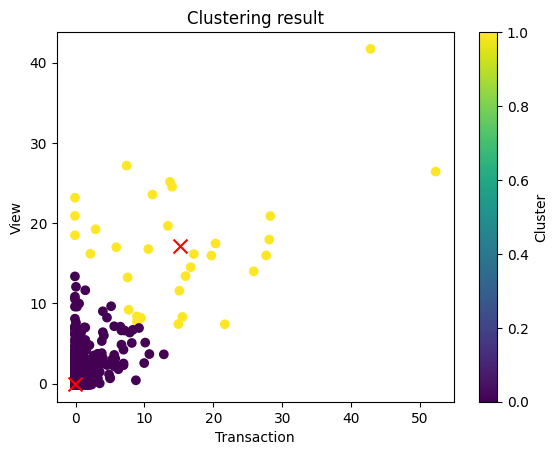

In [136]:
# Plot clusters
plt.scatter(predictions.select('transaction').collect(), predictions.select('view').collect(), c=predictions.select('prediction').collect(), cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=100)  # Plot cluster centers
plt.xlabel("Transaction")
plt.ylabel("View")
plt.title("Clustering result")
plt.colorbar(label="Cluster")
plt.show()

# Task 2 : Dựa vào các nhóm sản phẩm mà khách hàng xem, mua để clustering

In [142]:
viewed_and_purchased_items_df = viewed_and_purchased_items_df.select('purchase', 'view')
viewed_and_purchased_items_df = viewed_and_purchased_items_df.filter(viewed_and_purchased_items_df['view'] >= 10)
viewed_and_purchased_items_df = viewed_and_purchased_items_df.toPandas()

In [143]:
viewed_and_purchased_items_df

,purchase,view
0,2,3410
1,439,2539
2,9,2325
3,0,1854
4,60,1740
...,...,...
54127,0,10
54128,0,10
54129,0,10
54130,0,10


In [144]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(viewed_and_purchased_items_df)

# convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=viewed_and_purchased_items_df.columns)
scaled_df

,purchase,view
0,0.092670,51.025054
1,88.909499,37.837590
2,1.515365,34.597501
3,-0.313814,27.466278
4,11.880716,25.740250
...,...,...
54127,-0.313814,-0.452990
54128,-0.313814,-0.452990
54129,-0.313814,-0.452990
54130,-0.313814,-0.452990


In [145]:
viewed_and_purchased_items_df = spark.createDataFrame(scaled_df)

# Show the resulting PySpark DataFrame
viewed_and_purchased_items_df.show()

+-------------------+------------------+
|           purchase|              view|
+-------------------+------------------+
|0.09267019991791922|51.025053620423854|
|  88.90949887973007| 37.83759005196028|
| 1.5153653961620497|   34.597501414014|
|-0.3138141418661181|27.466278290309813|
| 11.880716111655001|25.740249763553386|
| 23.262277681608044|22.575864131166604|
|-0.3138141418661181|24.256470854587334|
|-0.3138141418661181|24.120205444580247|
| 12.490442624331058| 23.09064456897115|
| 15.945559529495373|22.530442327830908|
| 35.050323593345134|19.578025111010703|
|  28.74981629569255| 19.77485292546538|
|  9.848294402734815|20.547023582172205|
|  8.628841377382704| 20.42589877327702|
|-0.3138141418661181| 21.01638221664106|
| 18.587707751091617|17.776293578694784|
|  13.30341130789913| 17.01926352309986|
|-0.3138141418661181|18.018543196485158|
| 19.197434263767672| 16.51962368640721|
| 22.246066827147953|16.095686855274053|
+-------------------+------------------+
only showing top

In [147]:
# Add a column with row numbers
viewed_and_purchased_items_df = viewed_and_purchased_items_df.withColumn("row_id", monotonically_increasing_id())

# Filter out rows with row number greater than 0
viewed_and_purchased_items_df = viewed_and_purchased_items_df.filter(viewed_and_purchased_items_df.row_id > 0)

# Drop the row_id column
viewed_and_purchased_items_df = viewed_and_purchased_items_df.drop("row_id")

# Show the resulting DataFrame
viewed_and_purchased_items_df.show()

+-------------------+------------------+
|           purchase|              view|
+-------------------+------------------+
|  88.90949887973007| 37.83759005196028|
| 1.5153653961620497|   34.597501414014|
|-0.3138141418661181|27.466278290309813|
| 11.880716111655001|25.740249763553386|
| 23.262277681608044|22.575864131166604|
|-0.3138141418661181|24.256470854587334|
|-0.3138141418661181|24.120205444580247|
| 12.490442624331058| 23.09064456897115|
| 15.945559529495373|22.530442327830908|
| 35.050323593345134|19.578025111010703|
|  28.74981629569255| 19.77485292546538|
|  9.848294402734815|20.547023582172205|
|  8.628841377382704| 20.42589877327702|
|-0.3138141418661181| 21.01638221664106|
| 18.587707751091617|17.776293578694784|
|  13.30341130789913| 17.01926352309986|
|-0.3138141418661181|18.018543196485158|
| 19.197434263767672| 16.51962368640721|
| 22.246066827147953|16.095686855274053|
| 18.994192092875654|15.550625215245706|
+-------------------+------------------+
only showing top

In [148]:
# Create a VectorAssembler to assemble the 'transaction' and 'view' columns into a single 'features' column
assembler = VectorAssembler(inputCols=['purchase', 'view'], outputCol="features")

# Transform the DataFrame to include the "features" column
dataset_kmean = assembler.transform(viewed_and_purchased_items_df)

# Now let's try running the KMeans algorithm
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(dataset_kmean)

# Make predictions
predictions = model.transform(dataset_kmean)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)


Silhouette with squared euclidean distance = 0.9507084448682691
Cluster Centers: 
[-0.09216551 -0.10882368]
[3.42859568 4.01235456]


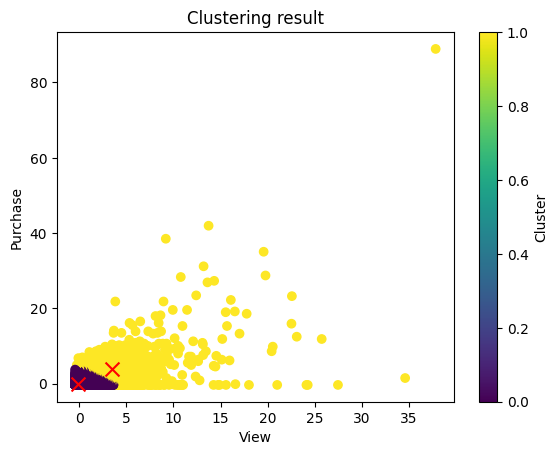

In [152]:
# Plot clusters
centers = np.array(centers)
plt.scatter(predictions.select('view').collect(), predictions.select('purchase').collect(), c=predictions.select('prediction').collect(), cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], marker='x', c='red', s=100)  # Plot cluster centers
plt.xlabel("View")
plt.ylabel("Purchase")
plt.title("Clustering result")
plt.colorbar(label="Cluster")
plt.show()